# COMP9444 Group Project 023
## Financial Phrasebank Sentiment Classification with LSTM/GloVe

**Created by:** Maximilian Keller (maximilian.keller@unsw.edu.au)

**Date Created:** 07/07/24

**Purpose:** The purpose of this notebook is to provide a baseline method for processing the FinancialPhraseBank dataset and apply a bidirectional 
LSTM RNN network with a fully connected classifier for multi-class sentiment classification. The GloVe embeddings are manually downloaded and 
applied to the input tokens. Some data analysis of the Financial Phrasebank Dataset is done at the start of this script. 

**Other Notes:** This script currently uses the entire dataset (maintaining an uneven class distrinution) through stratified data split by class label (i.e. same train/test class distribution). The train-test split is standardised across all implementations in this group (using train_test_split() with random state 42)

**Revision History:**

- 07/07/24 - Document created. Importing of GloVe embeddings + dataset. Initial exploration of data and pre-processing pipeline - Max
- 13/07/24 - Edits to optimise data processing and performance - Colin
- 14/07/24 - Edits to dataset split and subsampling for a uniform class distribution using "All Agree" data-sub-set and full dataset - Max
- 14/07/24 - Implmented LSTM model, training and testing loop using Phrasebank dataset. Only achieves <33% accuracy - Max 
- 15/07/24 - Achieved first functional code after feeding all hidden outputs (rather than only last) from LSTM to FC layer (accuracy 71%) - Max
- 16/07/24 - Modification to training parameters and removed ReLu activation after LSTM layer (accuracy 74%-80%) - Max
- 19/07/24 - 26/07/24 - Modifications to tokenisation, use of entire data set + 'sklearn' function train_test_split() with random state 42 - Max
- 27/07/24 - Final parameter tweaks. Re-organise notebook (accuracy 87+%) - Max
- 04/08/24 - Finalised notebook for submission. Added headings, comments and text to notebook - Max

**Assumed File Hierarchy:**
```
Root Folder (any name)
│
├── GloVe+LSTM-final-2.0.ipynb      # This script
│
├── GloVe                           # Directory for downloading embeddings
│
└── FinancialPhraseBank-v1.0        # Assumed to be pre-populated with data
```

## Import Libraries

In [173]:
# General functions
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# Functions for dataset handling
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
import nltk
from sklearn.utils import resample
import re

# Functions for data visualisation
from wordcloud import WordCloud
from sklearn.decomposition import PCA

# Functions for ANN model
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# CHange DIRectory to directory containing (this) script which invoked the Python interpreter
os.chdir(sys.path[0])
%pwd

'/Users/maximiliankeller/Documents/UNSW/COMP9444/group-project'

## 1. GloVe Embeddings

### Download Embeddings (downloads emmbedings files if not already present in GloVe directory)

In [174]:
def download_glove_embeddings(embeddings_path):
    if not os.path.exists(embeddings_path):
        os.makedirs(embeddings_path)

    # Download the GloVe embeddings to the specified directory
    zip_path = os.path.join(embeddings_path, "glove.6B.zip")

    if not os.path.exists(zip_path):
        print("Downloading GloVe embeddings to:", embeddings_path)
        os.system(f'wget -P {embeddings_path} http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip')

        # Unzip the downloaded file
        os.system(f'unzip -d {embeddings_path} {zip_path}')
    else:
        print("GloVe file alrerady in path: ", zip_path)

folder = "GloVe"
embeddings_path = os.path.join(sys.path[0], folder)

download_glove_embeddings(embeddings_path)

files = os.listdir(embeddings_path)
print("Files in directory after download and unzip:", files)

GloVe file alrerady in path:  /Users/maximiliankeller/Documents/UNSW/COMP9444/group-project/GloVe/glove.6B.zip
Files in directory after download and unzip: ['glove.6B.300d.txt', '.DS_Store', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'glove.6B.200d.txt', 'glove.6B.zip']


### Choose Embedding vector dimension to use and create python dictionary (key-value pair: word-vector)

In [175]:
dim = 300 # Embedding vector dimension (can be either 50, 100, 200, 300)

file = "glove.6B." + str(dim) + "d.txt"
file_path = embeddings_path + "/" + file

# List all files in the directory
files = os.listdir(embeddings_path)
print("Selected Embedding File:", file_path)
print("Files in directory:", files)

# Embeddings dict
words = dict()

def add_to_dict(d,filename):
  with open(filename, 'r')as f :
    for line in f.readlines():
      line = line.split(' ')
      
      try:
        d[line[0]] = np.array(line[1:], dtype = float)
      except:
        continue

add_to_dict(words,file_path)

# Show the first word embedding as an example
print("Example: ", list(words.items())[0])

Selected Embedding File: /Users/maximiliankeller/Documents/UNSW/COMP9444/group-project/GloVe/glove.6B.300d.txt
Files in directory: ['glove.6B.300d.txt', '.DS_Store', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'glove.6B.200d.txt', 'glove.6B.zip']
Example:  ('the', array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01

### Visualise some of the word embbedings using PCA dimensionality reduction to 2D (for fun)

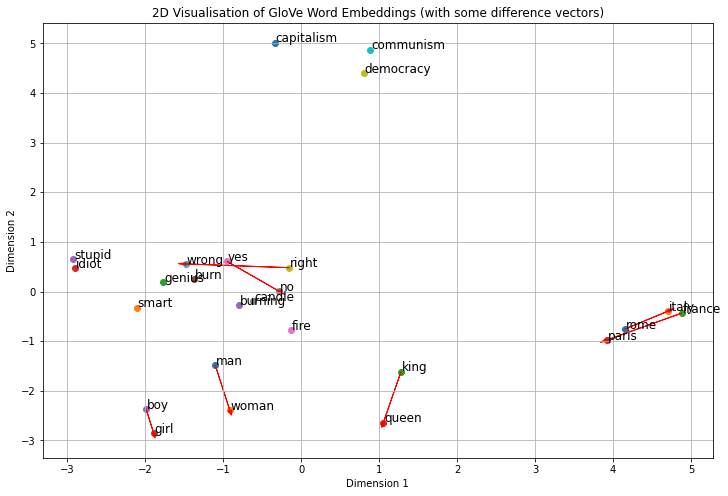

In [176]:
# Choose some words to plot their GloVe Embedding
selected_words = ['man', 'woman', 'king', 'queen', "boy", "girl", "yes", "no", "right", "wrong","rome","italy","france","paris","burning","burn","fire","candle","democracy","communism","capitalism","smart","genius","idiot","stupid"]

# Extract embeddings for selected words
word_vectors = np.array([words[word] for word in selected_words])

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Plotting the words in 2D space
plt.figure(figsize=(12, 8))
for word, vector in zip(selected_words, reduced_vectors):
    plt.scatter(vector[0], vector[1], marker='o')
    plt.text(vector[0] + 0.01, vector[1] + 0.01, word, fontsize=12)

# Draw difference vectors
for i in range(0, len(reduced_vectors) - 11, 2):
    start = reduced_vectors[i]
    end = reduced_vectors[i + 1]
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], 
              head_width=0.05, head_length=0.1, fc='red', ec='red')
    
plt.title('2D Visualisation of GloVe Word Embeddings (with some difference vectors)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


## 2. FinancialPhraseBank Dataset Pre-processing

### Create Pandas dataframe from entire dataset

In [177]:
# Directory containing the files
dataset_path = os.path.join(sys.path[0], "FinancialPhraseBank-v1.0")
print(dataset_path)

# List of all data sub-sets
files = [
    'Sentences_AllAgree.txt'
]

# Read and process all files
def load_and_process_file(file_name):
    # Read the dataset into a DataFrame with the specified encoding
    df_whole = pd.read_csv(os.path.join(dataset_path, file_name), sep='@', header=None, names=['text', 'label'], encoding='ISO-8859-1')
    print(f"{file_name} length: ", len(df_whole))
    
    # Remove any leading or trailing whitespace from the text and labels
    df_whole['text'] = df_whole['text'].str.strip()
    df_whole['label'] = df_whole['label'].str.strip()

    # Keep track of origin sub-set
    origin = file_name[10:12]
    if file_name[10:12] == 'Al':
        origin = 100
    df_whole['origin'] = origin

    return df_whole

# Load and combine datasets into one dataframe: df
dfs = [load_and_process_file(file) for file in files]
df = pd.concat(dfs, ignore_index=True)

# Remove any leading or trailing whitespace from the text and labels
df['text'] = df['text'].str.strip()
df['label'] = df['label'].str.strip()

# Display the first few rows of the DataFrame
print("Dataset head: ")
print(df.head())

# Calculate and print the number of entries for each class
class_counts = df['label'].value_counts()
num_records = len(df)
print("\nNumber of entries for each class:\n")
print(class_counts)
print("Total entries: ", num_records)

/Users/maximiliankeller/Documents/UNSW/COMP9444/group-project/FinancialPhraseBank-v1.0
Sentences_AllAgree.txt length:  2264
Dataset head: 
                                                text     label  origin
0  According to Gran , the company has no plans t...   neutral     100
1  For the last quarter of 2010 , Componenta 's n...  positive     100
2  In the third quarter of 2010 , net sales incre...  positive     100
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive     100
4  Operating profit totalled EUR 21.1 mn , up fro...  positive     100

Number of entries for each class:

label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64
Total entries:  2264


### Tokenisation of Dataset

In [178]:
# Use the 'basic_english' tokeniser from the NLTK library
nltk.download('wordnet')
tokenizer = get_tokenizer("basic_english")

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    tokens = tokenizer(text)
    return tokens

# Apply preprocessing to the text data
df['tokens'] = df['text'].apply(preprocess_text)

# Display the first few rows with tokens
print("\nFirst few rows with tokens:")
print(df[['text', 'tokens']].head(),end='\n\n')
print(df.columns, end='\n\n')

# Show some tokenised sentences
print("Examples of tokenised sentences:\n")
for i in range(5):
    print(df['tokens'][i])
print('')


First few rows with tokens:
                                                text  \
0  According to Gran , the company has no plans t...   
1  For the last quarter of 2010 , Componenta 's n...   
2  In the third quarter of 2010 , net sales incre...   
3  Operating profit rose to EUR 13.1 mn from EUR ...   
4  Operating profit totalled EUR 21.1 mn , up fro...   

                                              tokens  
0  [according, to, gran, ,, the, company, has, no...  
1  [for, the, last, quarter, of, 2010, ,, compone...  
2  [in, the, third, quarter, of, 2010, ,, net, sa...  
3  [operating, profit, rose, to, eur, 13, ., 1, m...  
4  [operating, profit, totalled, eur, 21, ., 1, m...  

Index(['text', 'label', 'origin', 'tokens'], dtype='object')

Examples of tokenised sentences:

['according', 'to', 'gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.']
['f

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maximiliankeller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Word Cloud Visualisation

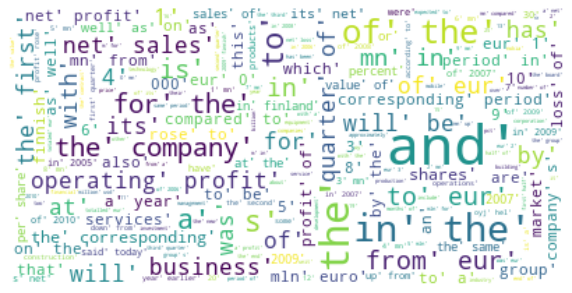

In [179]:
text = " ".join(df['tokens'].astype(str).tolist())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, max_font_size=40, relative_scaling=0.5).generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Custom processing based on GloVe dictionary contents and application of embeddings to tokens

In [180]:
# Function to normalise a single token (ie convert to proper GloVe 'embeddable' form)
def normalise_token(token):
    # Regex patterns
    number_pattern = r'\d+'
    currency_pattern = r'(eur|usd|gbp|jpy|cad|aud|chf|cny|inr)'
    million_pattern = r'(m|mn)'
    
    # Find numbers
    numbers = re.findall(number_pattern, token)
    numbers = numbers[0] if numbers else ''
    
    # Find currencies and map to full forms
    currency = re.findall(currency_pattern, token, re.IGNORECASE)
    currency = currency[0].lower() if currency else ''
    
    # Custom map created specifically from inspection of GloVe dictionary entries
    currency_map = {
        'usd': ['u.s. dollars'],
        'eur': ['euro'],
        'gbp': ['british', 'pounds'],
        'jpy': ['japanese', 'yen'],
        'cad': ['canadian', 'dollars'],
        'aud': ['australian', 'dollars'],
        'chf': ['swiss', 'francs'],
        'cny': ['chinese', 'yuan'],
        'inr': ['indian', 'rupees']
    }
    
    currency_words = currency_map.get(currency, [])
    
    # Check for million
    if re.search(million_pattern, token, re.IGNORECASE):
        if numbers:
            return [numbers, "million"] + currency_words + (['s'] if currency_words else [])
        else:
            return ["million"]
    
    # Return normalised token
    normalised_token = [numbers] + currency_words + (['s'] if currency_words else [])
    normalised_token = [t for t in normalised_token if t]  # Remove empty strings
    return normalised_token if normalised_token else [token]

# Function to normalise a list of tokens
def normalise_tokens(tokens):
    normalised = []
    for token in tokens:
        normalised.extend(normalise_token(token))
    return normalised

# Function to convert tokens to embeddings and collect tokens not in the dictionary
def tokens_to_embeddings(tokens, words):
    embeddings = []
    not_embedded = []
    for token in tokens:
        if token in words:
            embeddings.append(torch.tensor(words[token], dtype=torch.float))
        else:
            not_embedded.append(token)
    return embeddings, not_embedded

# Normalise tokens and then convert to embeddings
df['normalised_tokens'] = df['tokens'].apply(normalise_tokens)
df['embeddings_and_not_embedded'] = df['normalised_tokens'].apply(lambda x: tokens_to_embeddings(x, words))

# Split the returned structure into separate columns
df['embeddings'] = df['embeddings_and_not_embedded'].apply(lambda x: x[0])
df['not_embedded'] = df['embeddings_and_not_embedded'].apply(lambda x: x[1])

# Filter out empty sequences
df = df[df['embeddings'].apply(len) > 0]

# Filter out empty lists from the 'not_embedded' column
non_empty_not_embedded = df['not_embedded'][df['not_embedded'].apply(len) > 0]

# Finally, print tokens that still weren't embedded (mostly company names and acronyms)
print("Words that were omitted (no GloVe embedding):\n")
i =0
for not_embedded_token in non_empty_not_embedded:
    print(not_embedded_token[0])
    i += 1
print(i)

Words that were omitted (no GloVe embedding):

sepp+ñl+ñ
u.s. dollars
teleste
year-earlier
kapiteeli
eliiv
year-earlier
kaivo-oja
basware
teleste
aktia
+àland
aktia
vaahto
l+ñnnen
biohit
sepp+ñl+ñ
biohit
quarterended
ruukki
+àland
aktia
ponsse
konecranes
hkscan
digia
finland-based
fisas
konecranes
outotec
beltton-group
stonesoft
january-june
april-june
ragutis
svyturys-utenos
+àland
april-june
april-june
vv-auto
ixonos
affecto
u.s. dollars
vaias
konecranes
kauppalehti
passenger-related
svyturys-utenos
helsinki-based
vacon
basware
affecto
january-june
panostaja
olvi
olvi
ruukki
autotank
sponda
talvivaara
vacon
aspo
co-arranger
aldata
biohit
ruukki
tielinja
u.s. dollars
vnh
gotta-have
kalnapilio-tauro
uponor
basware
ruukki
africaand
kauniskangas
outotec
getinge
lindex
ragutis
peab
outotec
biohit
u.s. dollars
rtrks
talvivaara
proha
u.s. dollars
raute
u.s. dollars
elektrobit
finland-based
adpnews
outotec
affecto
adpnews
adpnews
august-october
u.s. dollars
vaias
efore
solteq
raute
083
geenr

### Final look at some dataset statistics (sentence length and class distribution)


Average sentence length: 24
Max sentence length:  79


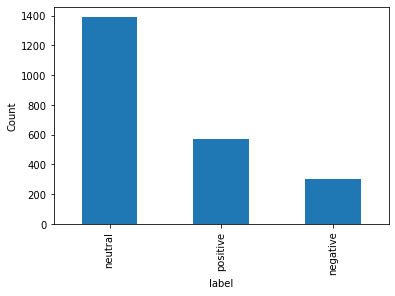

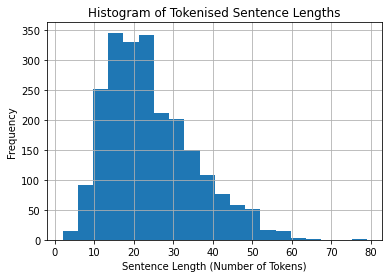

In [181]:
# Function to calculate the sentence length by token number
def sentence_length(tokens):
    return len(tokens)

# Add the new column to the DataFrame
df['sentence_length'] = df['embeddings'].apply(sentence_length)

# Histogram
class_counts.plot.bar(column="label", ylabel='Count')

# Calculate and print the average sentence length
average_sentence_length = df['sentence_length'].mean()
max_length = df['sentence_length'].max()
print("\nAverage sentence length:", int(average_sentence_length))
print("Max sentence length: ", max_length)

# Histogram
df.hist(column="sentence_length", bins=20)
plt.title('Histogram of Tokenised Sentence Lengths')
plt.xlabel('Sentence Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 3. Tensorisation of data (including stacking into tensor input matrix + label tensor encoding)

### Device Selection

In [182]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Convert input and labels to tensor

In [183]:
# Encode labels to numerical values
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label_encoded'] = df['label'].map(label_mapping)

# Convert labels to tensor
labels_tensor = torch.tensor(df['label_encoded'].values).to(device)

# Convert sequences to tensor
sequences = [torch.stack(seq) for seq in df['embeddings']]

# Print the dataframe as it stands now
print(df.columns)
#print(df.head)

Index(['text', 'label', 'origin', 'tokens', 'normalised_tokens',
       'embeddings_and_not_embedded', 'embeddings', 'not_embedded',
       'sentence_length', 'label_encoded'],
      dtype='object')


### Training/Test Split

In [184]:
# Use train_test_split to split the data and include indices in the train-test split
indices = np.arange(len(sequences))
train_indices, test_indices, padded_sequences_train, padded_sequences_test, labels_tensor_train, labels_tensor_test = train_test_split(
    indices, sequences, labels_tensor, test_size=0.2, random_state=42, stratify=df['label_encoded'])

In [201]:
# Verify train/test split
print("Train tensor length:",len(padded_sequences_train))
print("Test tensor length:",len(padded_sequences_test))

Train tensor length: 1811
Test tensor length: 453


### Manually pad input tensors with trailing zeroes

In [186]:
def pad_sequence(seq, max_length, dim):
    padding_length = max_length - seq.size(0)
    if padding_length > 0:
        padding = torch.zeros(padding_length, dim)
        return torch.cat((seq, padding), dim=0)
    else:
        return seq

padded_sequences_train = [pad_sequence(seq, max_length, dim) for seq in padded_sequences_train]
padded_sequences_test = [pad_sequence(seq, max_length, dim) for seq in padded_sequences_test]

# Convert to tensors
padded_sequences_train = torch.stack(padded_sequences_train).to(device)
padded_sequences_test = torch.stack(padded_sequences_test).to(device)

# Print sizes to verify
print(f"Total records in original dataset: {len(df)}")
print(f"Total records in training set: {len(padded_sequences_train)}")
print(f"Total records in test set: {len(padded_sequences_test)}")

print("Input matrix size for training: ", padded_sequences_train.size())  # Should print torch.Size([num_records_train, max_length, embedding_dim])
print("Input matrix size for testing: ", padded_sequences_test.size())  # Should print torch.Size([num_records_test, max_length, embedding_dim])

Total records in original dataset: 2264
Total records in training set: 1811
Total records in test set: 453
Input matrix size for training:  torch.Size([1811, 79, 300])
Input matrix size for testing:  torch.Size([453, 79, 300])


## 4. ANN Network Training

### Define the LSTM Model

In [187]:
# Toggle between bi-directional LSTM and uni-directional
use_bidirectional = True

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0, bidirectional=use_bidirectional)
        self.fc = nn.Linear(hidden_dim * (1 + int(use_bidirectional)) * seq_length, output_dim)  # hidden_dim * 2 because of bidirectional, * seq_length for all hidden states

    def forward(self, x):
        h_lstm, _ = self.lstm(x)                        # h_lstm: [batch_size, seq_length, hidden_dim*2]
        h_lstm = h_lstm.reshape(h_lstm.size(0), -1)     # flatten the tensor: [batch_size, seq_length * hidden_dim (* 2)]
        out = self.fc(h_lstm)                           # out: [batch_size, output_dim]
        return out

# Model parameters
embedding_dim = dim                                     # GloVe Embbeding dim. used
seq_length = max_length                                 # Maximum (padded) input sentence length dim.
hidden_dim = 100                                        # Hidden dim. (currently 1/2 of LSTM output)
output_dim = 3                                          # Number of classes
num_layers = 1                                          # Number of LSTM layers

### Apply the LSTM model

In [188]:
model = LSTMModel(embedding_dim, hidden_dim, output_dim, num_layers).to(device)

# Create a dataset and dataloader
dataset = TensorDataset(padded_sequences_train, labels_tensor_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Loss criterion and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### Train the LSTM model

In [189]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Training loop (with accuracy tracking)
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    for batch_sequences, batch_labels in dataloader:
        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_sequences)

        # Compute the loss
        loss = criterion(outputs, batch_labels)
        epoch_loss += loss.item()

        # Calculate accuracy
        epoch_correct += (outputs.argmax(1) == batch_labels).sum().item()
        epoch_total += batch_labels.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(dataloader)
    avg_accuracy = epoch_correct / epoch_total

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')


Epoch [1/10], Loss: 0.8046, Accuracy: 0.6521
Epoch [2/10], Loss: 0.4111, Accuracy: 0.8316
Epoch [3/10], Loss: 0.2096, Accuracy: 0.9271
Epoch [4/10], Loss: 0.0925, Accuracy: 0.9757
Epoch [5/10], Loss: 0.0300, Accuracy: 0.9961
Epoch [6/10], Loss: 0.0126, Accuracy: 0.9983
Epoch [7/10], Loss: 0.0072, Accuracy: 0.9994
Epoch [8/10], Loss: 0.0074, Accuracy: 0.9989
Epoch [9/10], Loss: 0.0140, Accuracy: 0.9961
Epoch [10/10], Loss: 0.0044, Accuracy: 0.9994


## 5. ANN Network Performance Testing and Evaluation

### Training Dataset Performance

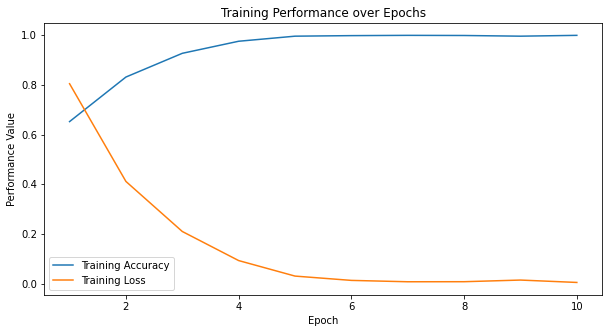

In [190]:
# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Performance Value')
plt.title('Training Performance over Epochs')
plt.legend()
plt.show()

In [191]:
# Put the model in evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions for the entire dataset
    outputs = model(padded_sequences_train)

    # Apply softmax to get probabilities (not really required)
    probabilities = F.softmax(outputs, dim=1)

    # Convert outputs to predicted classes
    _, predicted_labels = torch.max(probabilities, dim=1)

# Move predictions back to the CPU if necessary
predicted_labels = predicted_labels.cpu()

correct_predictions = (predicted_labels == labels_tensor_train.cpu()).sum().item()
total_predictions = labels_tensor_train.size(0)
accuracy = correct_predictions / total_predictions

print(f'Final accuracy on the training dataset: {accuracy * 100:.2f}%')

Final accuracy on the training dataset: 100.00%


### Training Dataset Performance Examples

In [192]:
# Map numerical labels back to text labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels_test_text = [reverse_label_mapping[label] for label in predicted_labels.numpy()]

# Function to display examples with original text and labels vs predicted labels
def display_examples(df, predicted_labels_text, indices, num_examples=5):
    for i in range(min(num_examples, len(indices))):
        index = indices[i]
        print(f"Example {i + 1}:")
        print(f"Original Text: {df['text'].iloc[index]}")
        print(f"Original Label: {df['label'].iloc[index]}")
        print(f"Predicted Label: {predicted_labels_text[i]}")
        print("-" * 30)

predicted_labels_train_text = [reverse_label_mapping[label] for label in predicted_labels.cpu().numpy()]
display_examples(df, predicted_labels_train_text, train_indices, num_examples=50)

Example 1:
Original Text: A total of $ 78 million will be invested in the project .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 2:
Original Text: Coffee will be served starting at 14:30 EET as well as after the event .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 3:
Original Text: CapMan , with offices in Helsinki , Stockholm , Copenhagen and Oslo , manages Nordic buyout , mezzanine , technology , life science and real estate funds with approximately EUR2 .6 bn in total capital .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 4:
Original Text: The price will be specified at the completion date .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 5:
Original Text: The site will cover over six hectares .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 6:
Original Text: The group intends

### Test Dataset performance

In [199]:
# Evaluate on the test set
with torch.no_grad():
    outputs_test = model(padded_sequences_test)
    probabilities_test = F.softmax(outputs_test, dim=1)
    _, predicted_labels_test = torch.max(probabilities_test, dim=1)

# Move predictions back to the CPU if necessary
predicted_labels_test = predicted_labels_test.cpu()

# Can choose False to show only false predictions (for analysis)
show_all = True

# Display examples from the test set
def display_test_examples(df, predicted_labels, indices, num_examples=5):
    for i in range(min(num_examples, len(indices))):
        index = indices[i]
        original_text = df['text'].iloc[index]
        original_label = df['label'].iloc[index]
        original_set = df['origin'].iloc[index]
        predicted_label = reverse_label_mapping[predicted_labels[i].item()]
        if (original_label!=predicted_label or show_all):
            print(f"Example {i + 1}:")
            print(f"Data sub-set: {original_set}")
            print(f"Original Text: {original_text}")
            print(f"Original Label: {original_label}")
            print(f"Predicted Label: {predicted_label}")
            print("-" * 30)

# Display examples from the test set
display_test_examples(df, predicted_labels_test, test_indices, num_examples=len(padded_sequences_test))

# Calculate accuracy on the test set
correct_predictions = (predicted_labels_test == labels_tensor_test.cpu()).sum().item()
total_predictions = labels_tensor_test.size(0)
accuracy = correct_predictions / total_predictions

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Example 1:
Data sub-set: 100
Original Text: The Finnish national carrier said net loss in April through June was euro26 million , down from a net profit of euro13 million a year earlier .
Original Label: negative
Predicted Label: negative
------------------------------
Example 2:
Data sub-set: 100
Original Text: The Group owns and operates a fleet of more than 800dwt , while container capacity is 17,000 TEUs , and manages a diversified fleet of its own railway rolling stock of over 17,000 units .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 3:
Data sub-set: 100
Original Text: The EPS improved to EUR0 .38 from EUR0 .27 .
Original Label: positive
Predicted Label: neutral
------------------------------
Example 4:
Data sub-set: 100
Original Text: The value of this kind of order amounts usually between Euro 2 and 3 million .
Original Label: neutral
Predicted Label: neutral
------------------------------
Example 5:
Data sub-set: 100
Original Text: P

### Confusion Matrix and Report for Test Dataset

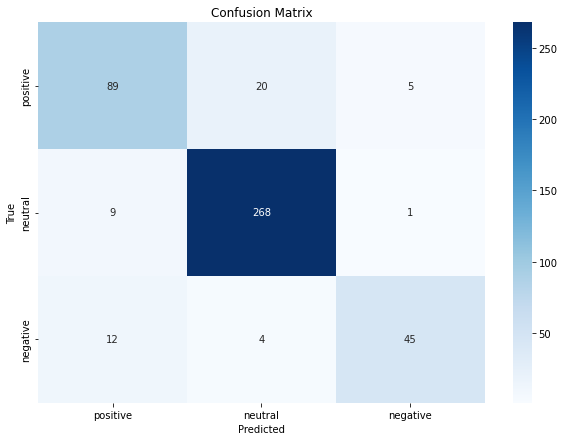

              precision    recall  f1-score   support

    positive       0.81      0.78      0.79       114
     neutral       0.92      0.96      0.94       278
    negative       0.88      0.74      0.80        61

    accuracy                           0.89       453
   macro avg       0.87      0.83      0.85       453
weighted avg       0.89      0.89      0.89       453



In [194]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(labels_tensor_test.cpu(), predicted_labels_test)

# Plot confusion matrix and save to file
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('GloVe+LSTM_confusion_matrix.png')  # Save the plot as a PNG file
plt.show()

# Generate and save classification report
report = classification_report(labels_tensor_test.cpu(), predicted_labels_test, target_names=['positive', 'neutral', 'negative'])
print(report)  # Optionally print the report

with open('GloVe+LSTM_classification_report.txt', 'w') as f:
    f.write(report)  # Save the report to a text file

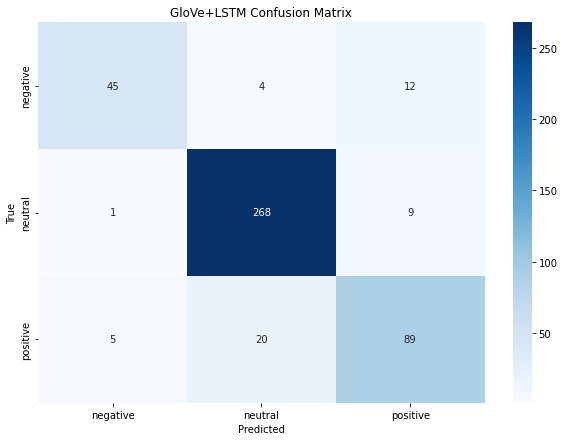

In [195]:
import torch
import matplotlib.pyplot as plt

def invert_labels(tensor):
    tensor = tensor.clone()  # Clone the tensor to avoid modifying the original one
    tensor[tensor == 0] = 3  # Temporary value to avoid conflict
    tensor[tensor == 2] = 0
    tensor[tensor == 3] = 2
    return tensor

# Invert the labels
labels_tensor_test_inverted = invert_labels(labels_tensor_test)
predicted_labels_test_inverted = invert_labels(predicted_labels_test)

# Generate confusion matrix
cm = confusion_matrix(labels_tensor_test_inverted.cpu(), predicted_labels_test_inverted)

# Plot confusion matrix and save to file
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GloVe+LSTM Confusion Matrix')
plt.savefig('GloVe+LSTM_confusion_matrix.png')  # Save the plot as a PNG file
plt.show()
